# Self-Driving Car Engineer Nanodegree
## Project 3: (Deep Learning) Build a Traffic Sign Recognition Classifier

In this project, I used what I've learned about deep neural networks and convolutional neural networks to classify traffic signs. I trained and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained.

In [1]:
# Load and import dependencies 
import numpy as np
import pickle
import glob
import csv
import cv2

from sklearn.utils import shuffle

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
def duplicates(lst, item):    
    """ returns a list with indexes where element 'item' is repeated in list 'lst'
    Args:
        lst: `list` list to look for repeated elements  
        item: `undefined` elements to look indexes where is repeated in list 'lst'
    Returns: list with indexes where the element is repeated in input list
    """
    return [i for i, x in enumerate(lst) if x == item]


def plot_dataset(means_training, means_validation, means_test, save_name = None):

    """ plots dataset data distribution
    Args:
        means_training: `list` list with the amount of training samples for each class 
        means_validation: `list` list with the amount of validation samples for each class
        means_test: `list` list with the amount of testing samples for each class
    Returns:
    """
    
    # Plot parameters
    plt.rcParams["figure.figsize"] = (20,5)
    fig, ax = plt.subplots()
    index = np.arange(n_classes)
    bar_width = 0.2

    # Plot training, validation and test datasets
    rects1 = ax.bar(index, means_training, bar_width, alpha=0.4, color='b', label='Training')
    rects2 = ax.bar(index + bar_width, means_validation, bar_width, alpha=0.4, color='r', label='Validation')
    rects3 = ax.bar(index + 2*bar_width, means_test, bar_width, alpha=0.4, color='g', label='Test')

    # Plotting the graph
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Dataset Description')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(map(str, range(n_classes + 1)))
    ax.legend()
    fig.tight_layout()
    if save_name is not None:
        plt.savefig(None)
    plt.show()


---

## Step 1: Dataset Loading, Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [3]:
# set where the training and testing data are saved
validation_file = "traffic-signs-data/valid.p"
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

# Read each file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Get features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Shuffle all datasets
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)


### Basic Summary of the Data Set

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Total number of samples in dataset
n_total = n_test + n_validation + n_train

# Shape of an traffic sign image
image_shape = X_train.shape[1:]


# Get from csv file number of clases and descriptions
classes_dics = []
with open('traffic-signs-data/signnames.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for idx, row in enumerate(csv_reader):
        if idx > 0:
            
            train_idx = duplicates(list(y_train), int(row[0]))
            valid_idx = duplicates(list(y_valid), int(row[0]))
            test_idx = duplicates(list(y_test), int(row[0]))
            
            classes_dics.append({
                "id": int(row[0]), 
                "description": row[1], 
                "train": len(train_idx), 
                "vali": len(valid_idx), 
                "test": len(test_idx), 
                "train_idx": train_idx, 
                "vali_idx": valid_idx,
                "test_idx": test_idx
            })

# Unique classes/labels in the dataset.
n_classes = len(classes_dics)
            
print("-"*57)
print("| id\t| train\t\t| validation\t| testing\t|")
print("-"*57)
for dic in classes_dics:
    print("| {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t|  {}".format(
        dic["id"], 
        dic["train"]/n_train*100, dic["train"], 
        dic["vali"]/n_validation*100, dic["vali"], 
        dic["test"]/n_test*100, dic["test"], 
        dic["description"][0:30]))
print("-"*57,"\n")    
    
print("{:.2f}% - Number of training examples \t= {}".format(n_train/n_total*100, n_train))
print("{:.2f}% - Number of validation examples \t= {}".format(n_validation/n_total*100, n_validation))
print("{:.2f}% - Number of testing examples \t= {}".format(n_test/n_total*100, n_test))

print("\nImage data shape =", image_shape)
print("Number of classes =", n_classes)


---------------------------------------------------------
| id	| train		| validation	| testing	|
---------------------------------------------------------
| 0	| 0.52% - 180	| 0.68% - 30	| 0.48% - 60	|  Speed limit (20km/h)
| 1	| 5.69% - 1980	| 5.44% - 240	| 5.70% - 720	|  Speed limit (30km/h)
| 2	| 5.78% - 2010	| 5.44% - 240	| 5.94% - 750	|  Speed limit (50km/h)
| 3	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (60km/h)
| 4	| 5.09% - 1770	| 4.76% - 210	| 5.23% - 660	|  Speed limit (70km/h)
| 5	| 4.74% - 1650	| 4.76% - 210	| 4.99% - 630	|  Speed limit (80km/h)
| 6	| 1.03% - 360	| 1.36% - 60	| 1.19% - 150	|  End of speed limit (80km/h)
| 7	| 3.71% - 1290	| 3.40% - 150	| 3.56% - 450	|  Speed limit (100km/h)
| 8	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (120km/h)
| 9	| 3.79% - 1320	| 3.40% - 150	| 3.80% - 480	|  No passing
| 10	| 5.17% - 1800	| 4.76% - 210	| 5.23% - 660	|  No passing for vehicles over 3
| 11	| 3.36% - 1170	| 3.40% - 150	| 3.33% - 420	|  Right-of

### Exploratory visualization of the dataset

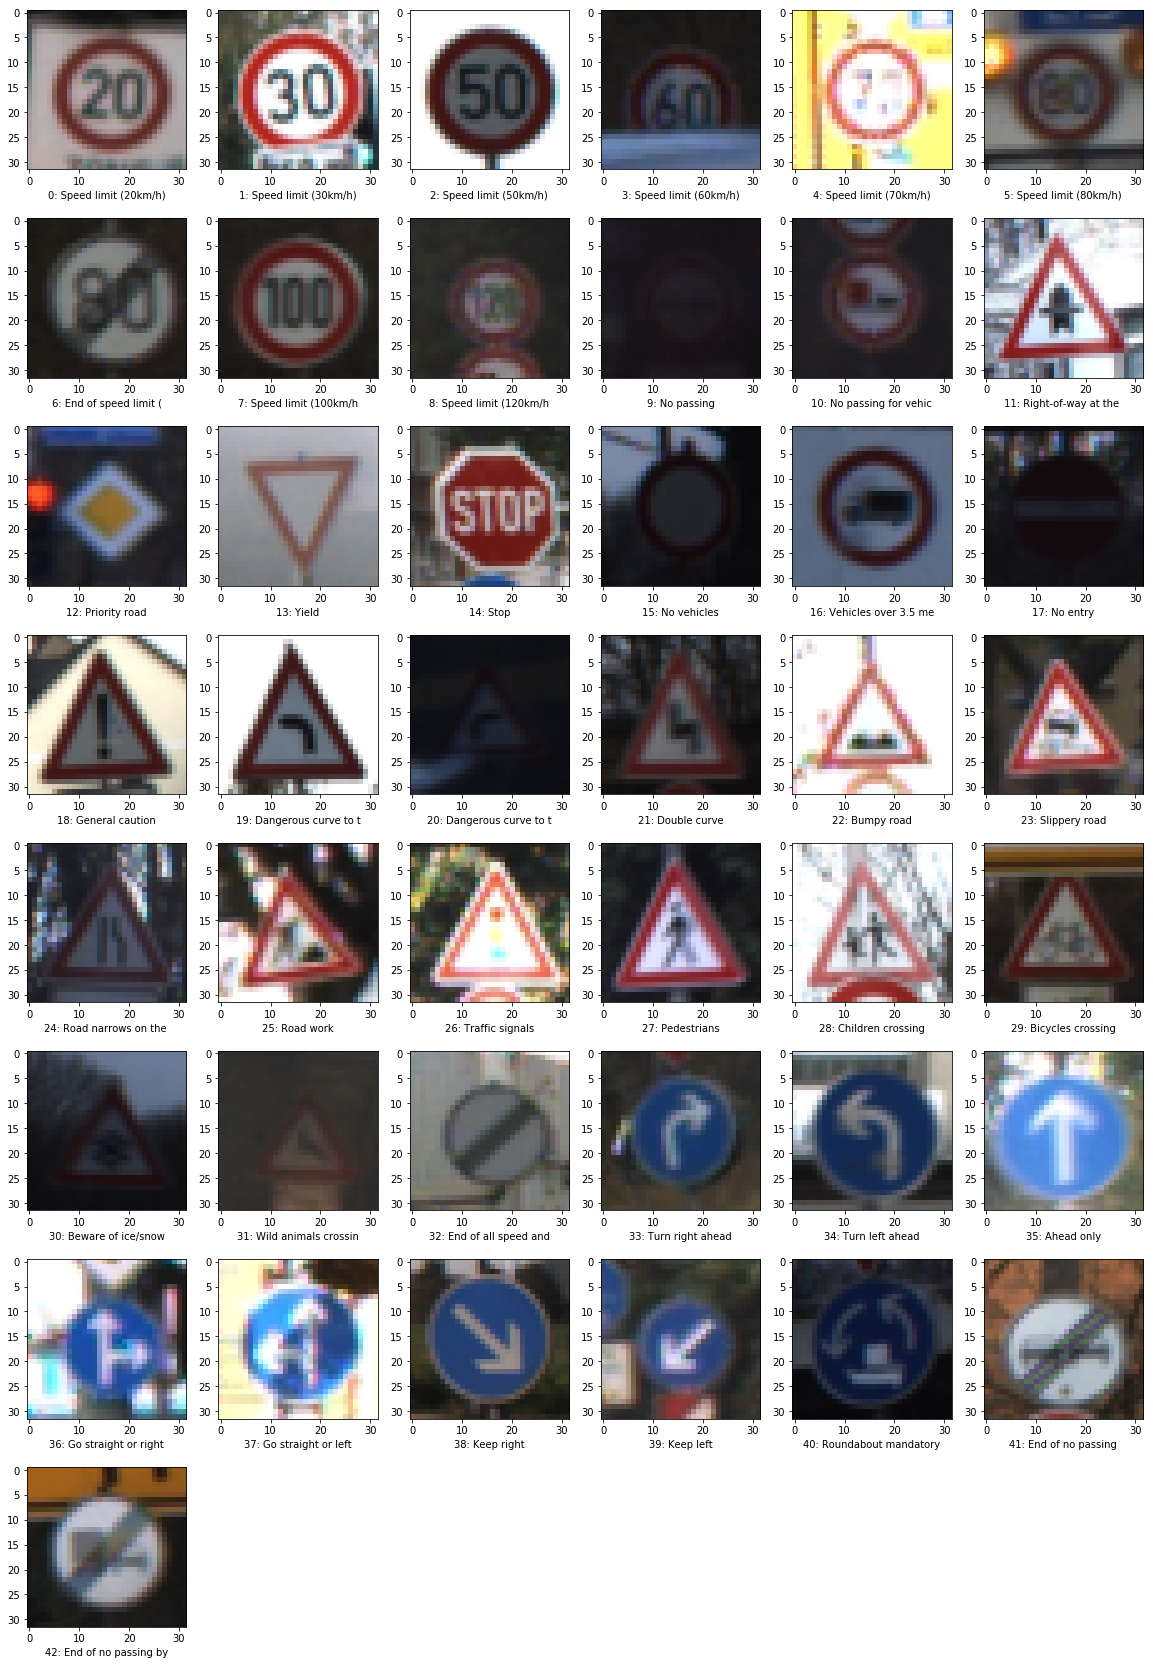

In [5]:
# Plot a random sample for each class
plt.figure(figsize=(20,30))
columns = 6
for idx in range(0, n_classes):
    len_idx = len(classes_dics[idx]["train_idx"])
    idx_data = classes_dics[idx]["train_idx"][np.random.randint(len_idx)]
    ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
    plt.imshow(X_train[idx_data])
    ax.set_xlabel(str(idx)+": "+classes_dics[idx]["description"][0:20])
plt.savefig('writeup_files/dataset_random_visualization.png')
plt.show()


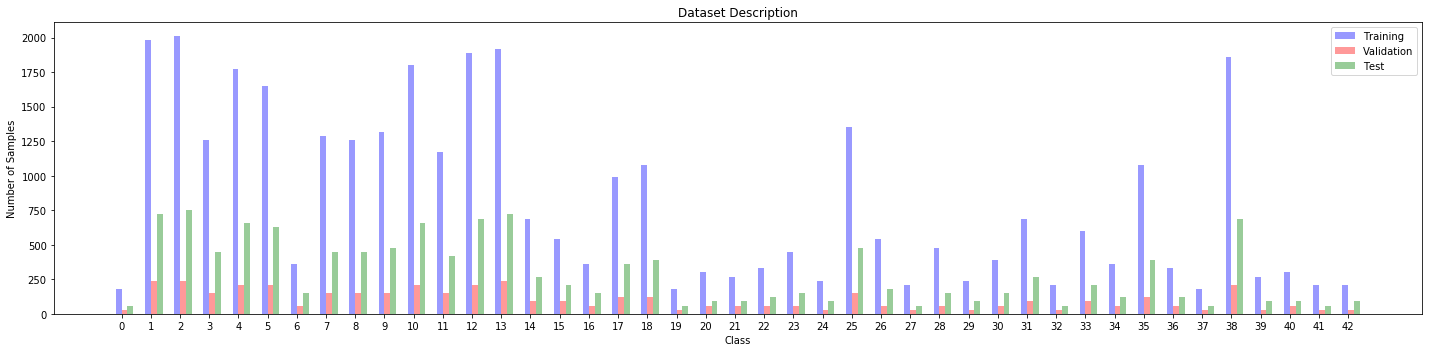

In [6]:
# Get the total of samples for each class for validation, training and test data sets
means_validation = [d['vali'] for d in classes_dics if 'vali' in d]
means_training = [d['train'] for d in classes_dics if 'train' in d]
means_test = [d['test'] for d in classes_dics if 'test' in d]
plot_dataset(means_training, means_validation, means_test, save_name = 'writeup_files/dataset_description_original_data.png')


### Data Augmentation:  Data Set Pre-processing

In [54]:
# Normalizate and convert to gray scale
def norm_and_gray(img):
    if img.dtype == np.uint8:
        img = np.array(img/255.0, dtype=np.float32)
    dst = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return dst.reshape(32,32,1)

# Add gaussian noise to image
def add_noisy(img, *argv):
    row,col,ch= img.shape
    mean = argv[0]
    var = argv[1]
    sigma = var**argv[2]
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = img + gauss
    noisy = np.clip(noisy, a_min = 0, a_max = 255)
    noisy = np.uint8(noisy)
    return noisy

# Rotate image
def rot_pers_transform(img, ang=30):
    rows, cols, _ = img.shape
    angle = np.random.randint(-ang, ang)
    M = cv2.getRotationMatrix2D((int(cols/2),int(rows/2)), angle, 1)
    dst = cv2.warpAffine(img, M, (cols, rows)).astype(int)
    dst = np.uint8(dst)
    return dst

# Complete and balance data
def balance_data(data, classes_dics):
    means_data = [d['vali'] for d in classes_dics if 'vali' in d]


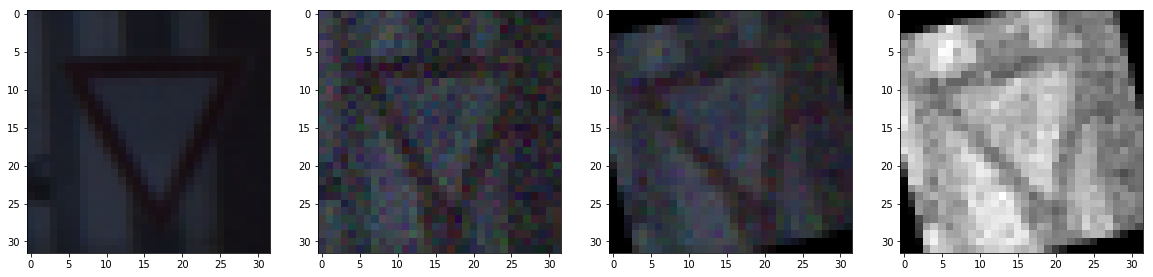

In [57]:
idx = np.random.randint(len(X_valid))
# X_valid_gray = [norm_and_gray(img) for img in X_valid]

X_valid_image = X_valid[idx]

X_valid_noise = add_noisy(X_valid_image, 20, 100, 0.5)
X_valid_rota  = rot_pers_transform(X_valid_noise)
X_valid_gray  = norm_and_gray(X_valid_rota)

_, vframes = plt.subplots(nrows=1, ncols=4)
vframes[0].imshow(X_valid_image)

vframes[1].imshow(X_valid_noise)
vframes[2].imshow(X_valid_rota)
vframes[3].imshow(X_valid_gray.squeeze(), cmap='gray')


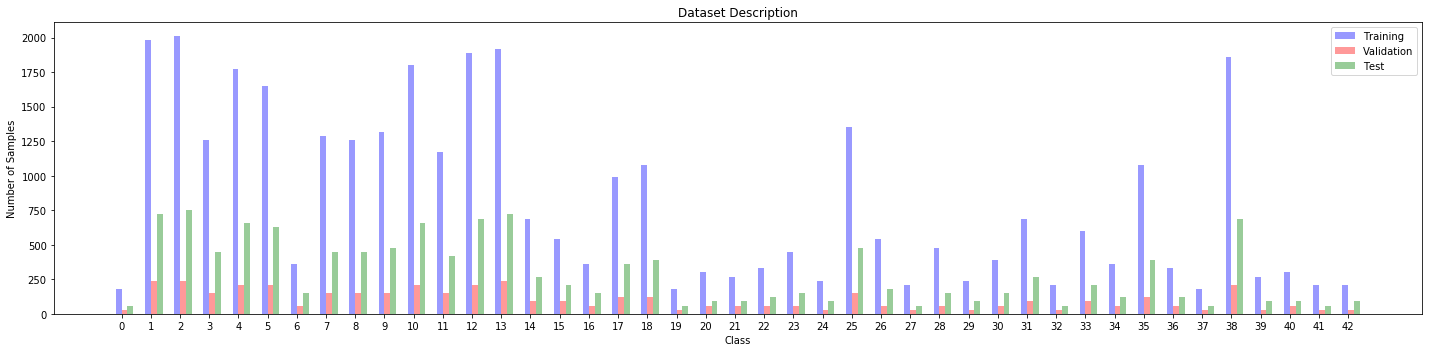

In [11]:
# Get the total of samples for each class for validation, training and test data sets
means_validation = [d['vali'] for d in classes_dics if 'vali' in d]
means_training = [d['train'] for d in classes_dics if 'train' in d]
means_test = [d['test'] for d in classes_dics if 'test' in d]
plot_dataset(means_training, means_validation, means_test, save_name = 'writeup_files/dataset_description_balanced_data.png')


----

## Step 2: Designing and Testing a Model Architecture

Next the designing and implementation of a deep learning model that learns to recognize traffic signs. Model was trained and tested with the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The Network is inspired in the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) and the lecture [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

There are various aspects were considered in this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Model Architecture
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [12]:
# Load and import dependencies for model
import tensorflow as tf
from tensorflow.contrib.layers import flatten


In [13]:
# Hyper parameters
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.01
NUM_CHANNELS = 3
DATA_SRC_SIZE = (32, 32)


In [14]:
def BetaNet(x):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases 
    # for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, NUM_CHANNELS, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1) # Activation.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2) # Activation.
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1) # Activation.

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2) # Activation.

    # Layer 5: Fully Connected. Input = 84. Output = n_classes = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# `x` is a placeholder for a batch of input images.
x = tf.placeholder(tf.float32, (None, DATA_SRC_SIZE[0], DATA_SRC_SIZE[1], NUM_CHANNELS))
# `y` is a placeholder for a batch of output labels.
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, n_classes)

logits = BetaNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [36]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


## Model Training
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [40]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {}: Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
        
    saver.save(sess, './model_results')
    print("Model saved")
    

Training...

EPOCH 1: Validation Accuracy = 0.507
EPOCH 2: Validation Accuracy = 0.700
EPOCH 3: Validation Accuracy = 0.781
EPOCH 4: Validation Accuracy = 0.811
EPOCH 5: Validation Accuracy = 0.820
Model saved


---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, more data was randomly downloaded from the web and used in the model to predict the traffic sign type.


### Loading New Data sets

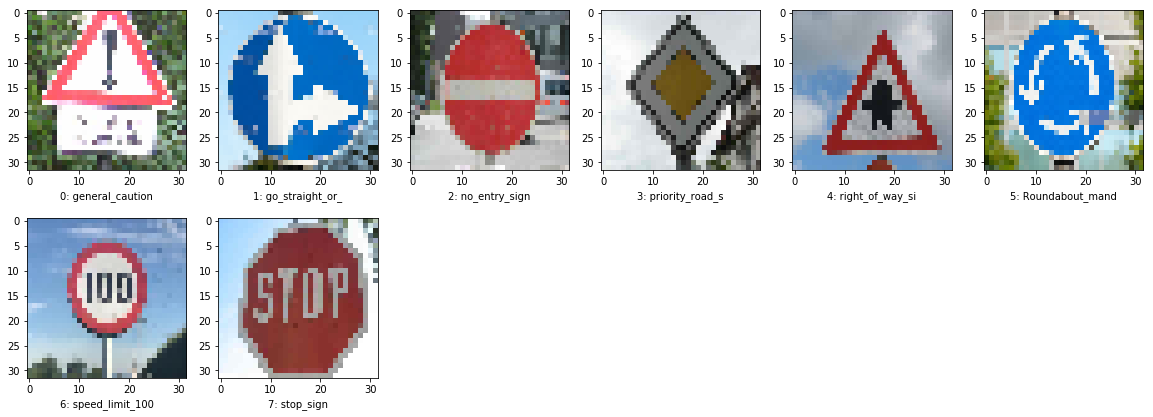

In [54]:
path = "traffic-signs-data/other_signs"
extensions = ["jpg","gif","png","tga"]

# Load images in 'path'
image_path_list = [item for i in [glob.glob(path+'/*.%s' % ext) for ext in extensions] for item in i]
image_list = np.asarray([cv2.cvtColor(cv2.resize(cv2.imread(img_path), image_shape[:2]), cv2.COLOR_BGR2RGB) \
              for idx, img_path in enumerate(image_path_list)])

# Visualize new dataset
plt.figure(figsize=(20,30)); columns = 6
for idx in range(0, len(image_list) if len(image_list) <= 12 else 12):
    ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
    plt.imshow(image_list[idx])
    ax.set_xlabel(str(idx)+": "+image_path_list[idx].split("/")[-1].split(".")[0][0:15])
plt.savefig('writeup_files/new_data_set.png')
plt.show()


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

NameError: name 'saver' is not defined